# Ielādējam tokenizer / modeli (LVBERT) caur HuggingFace

In [9]:
from transformers import AutoTokenizer, TFBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("AiLab-IMCS-UL/lvbert")
model = TFBertForSequenceClassification.from_pretrained("AiLab-IMCS-UL/lvbert", from_pt=True, num_labels=10)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
enc = tokenizer.encode("Šis žagaru saišķis")
dec = tokenizer.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Encode: [2, 934, 30266, 1055, 14, 91, 12, 4417, 7, 3]
Decode: [CLS] Šis žagaru saišķis [SEP]


# Datu ielāde

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lvclassify_helpers import getdata10cat

df = getdata10cat()
df.head()
sentences=df['body']
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
labels=df['encod_cat']
print(df.head(5))
print(df.category.value_counts())
print(df.encod_cat.value_counts())

  category                                               body  encod_cat
0   Sports  Reaģējot uz  Latvijas Paralimpiskās komitejas ...          8
1   Sports  Latvijas tenisiste  Jeļena Ostapenko  šodien Ķ...          8
2   Sports  Latvijas Sporta federāciju padome  (LSFP) iebi...          8
3   Sports  Jaunais sporta finansējuma modelis samazinās f...          8
4   Sports  Aleksandrs  un  Mihails Samoilovi  piektdien S...          8
category
Sports           1200
Politika         1200
Literatūra       1200
Finanses         1200
Atpūta           1200
Kriminālziņas    1200
Kino             1200
Mūzika           1200
Auto             1200
Tehnoloģijas     1200
Name: count, dtype: int64
encod_cat
8    1200
7    1200
5    1200
2    1200
0    1200
4    1200
3    1200
6    1200
1    1200
9    1200
Name: count, dtype: int64


# Tokenizācija

In [12]:
import numpy as np
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =312,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Newbox\Documents\Python\Lib\site-packages\transformers\tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(12000, 12000, 12000)

# Sadalam datus apmacibai/parbaudei

In [13]:
from sklearn.model_selection import train_test_split
apmacibas_ievade,validacijas_ievade,apmacibas_birkas,validacijas_birkas,apmacibas_maskas,validacijas_maskas=train_test_split(input_ids,labels,attention_masks,test_size=0.2, stratify=labels, random_state=42)

# Modeļa apmācība

In [14]:
import tensorflow as tf

# Saglabajam labako modeli pec apmacibas zuduma starp epohiem
model_save_path='./models/bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
print(model.summary())

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110620416 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 110628106 (422.01 MB)
Trainable params: 110628106 (422.01 MB)
Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________
None


In [15]:
history=model.fit([apmacibas_ievade,apmacibas_maskas],apmacibas_birkas,batch_size=32,epochs=5,validation_data=([validacijas_ievade,validacijas_maskas],validacijas_birkas),callbacks=callbacks)

Epoch 1/5
300/300 [==============================] - 8621s 29s/step - loss: 0.3766 - accuracy: 0.9181 - val_loss: 0.1374 - val_accuracy: 0.9629
Epoch 2/5
300/300 [==============================] - 49507s 165s/step - loss: 0.0939 - accuracy: 0.9777 - val_loss: 0.1224 - val_accuracy: 0.9704
Epoch 3/5
300/300 [==============================] - 8335s 28s/step - loss: 0.0553 - accuracy: 0.9871 - val_loss: 0.1407 - val_accuracy: 0.9663
Epoch 4/5
300/300 [==============================] - 8355s 28s/step - loss: 0.0355 - accuracy: 0.9912 - val_loss: 0.1278 - val_accuracy: 0.9692
Epoch 5/5
300/300 [==============================] - 8319s 28s/step - loss: 0.0239 - accuracy: 0.9943 - val_loss: 0.2013 - val_accuracy: 0.9575


# Ielādējam veiksmīgāko modeli, novērtējam / vizualizējam

75/75 [==============================] - 504s 7s/step
(2400,)
(2400,)
              precision    recall  f1-score   support

           0     0.9875    0.9875    0.9875       240
           1     0.9714    0.9917    0.9814       240
           2     0.9153    0.9458    0.9303       240
           3     0.9876    0.9958    0.9917       240
           4     0.9957    0.9583    0.9766       240
           5     0.9711    0.9792    0.9751       240
           6     0.9793    0.9833    0.9813       240
           7     0.9745    0.9542    0.9642       240
           8     0.9834    0.9875    0.9854       240
           9     0.9404    0.9208    0.9305       240

    accuracy                         0.9704      2400
   macro avg     0.9706    0.9704    0.9704      2400
weighted avg     0.9706    0.9704    0.9704      2400



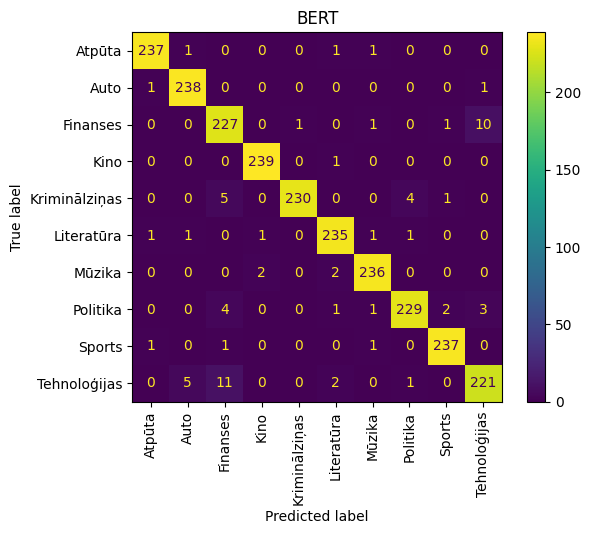

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Ieladejam lidz sim veiksmigaka modela svarus
model_load_path='./models/bert_model_0.9704.h5'
model.load_weights(model_load_path)

y_pred = model.predict([validacijas_ievade,validacijas_maskas], batch_size=32)
y_pred = np.argmax(y_pred.logits, axis=1)
print(validacijas_birkas.shape)
print(y_pred.shape)
cm = confusion_matrix(validacijas_birkas, y_pred)
labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
plot.plot(xticks_rotation=90)
plot.ax_.set_title("BERT")
print(classification_report(validacijas_birkas, y_pred, digits=4))
clsf_report = pd.DataFrame(classification_report(y_true = validacijas_birkas, y_pred = y_pred, output_dict=True)).transpose()
clsf_report.to_csv('Report BERT.csv', index= True)